In [1]:
# =========================
# X - IMPORTS
# =========================

### /// RTOFS ///
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import numpy as np
import xarray as xr

In [2]:
# =========================
# CONFIG
# =========================

from SUP_config import *

config, waypoints = GGS_config_static()
directory = GGS_config_output(config)


Glider Guidance System (GGS) Configuration:
Glider_name: Yucatan

Max depth: 1000.0
Avg velocity: 0.5
Battery capacity: 1000
Battery drain: 5
Satisfying radius: 1000
Waypoint 1: (15.365189027409214, -90.57125927041142)
Waypoint 2: (23.25501019140833, -80.12008055595216)



In [3]:
# =========================
# [RTOFS] DATA PROCESSING
# =========================

### CLASS:
class RTOFS():
    
    '''
    Class for handling RTOFS data.

    Attributes:
    - data_orig (xarray.Dataset): original RTOFS data
    - data (xarray.Dataset): RTOFS data
    - x (np.array): x-coordinates of the RTOFS grid
    - y (np.array): y-coordinates of the RTOFS grid
    - grid_lons (np.array): longitudes of the RTOFS grid
    - grid_lats (np.array): latitudes of the RTOFS grid
    - rtofs_qc (xarray.Dataset): RTOFS data for quality control

    Methods:
    - __init__ (initialize the RTOFS instance)
    - rtofs_load (fetch the RTOFS data from the given URL and set its coordinates)
    - rtofs_subset (subset the RTOFS data based on the bounding box created by the given points)
    '''

    ### FUNCTION:
    def __init__(self) -> None:
        
        '''
        Initialize the RTOFS instance.

        Args:
        - None

        Returns:
        - None
        '''

        self._data_orig = self.rtofs_load()
        self._data_orig = self._data_orig.set_coords(['lat', 'lon'])
        self.data = self._data_orig.copy()

        self.x = self.data.x.values
        self.y = self.data.y.values
        self.grid_lons = self.data.lon.values[0,:]
        self.grid_lats = self.data.lat.values[:,0]

        self.rtofs_qc = self._data_orig.copy()

    ### FUNCTION:
    def rtofs_load(self):
        
        '''
        Fetch the RTOFS data from the given URL and set its coordinates.

        Args:
        - None

        Returns:
        - rtofs_raw (xarray.Dataset): RTOFS data
        '''

        rtofs_access = "https://tds.marine.rutgers.edu/thredds/dodsC/cool/rtofs/rtofs_us_east_scraped"

        try:
            rtofs_raw = xr.open_dataset(rtofs_access).set_coords(['lon', 'lat'])
            rtofs_raw.attrs['model'] = 'RTOFS'
            rtofs_raw = rtofs_raw.isel(time=-1)
            return rtofs_raw
        except Exception as e:
            print(f"Error fetching RTOFS data: {e}")
            return None
    
    ### FUNCTION:
    def rtofs_subset(self, config, waypoints, buffer=0.5, subset=True):

        '''
        Subset the RTOFS data based on the bounding box created by the given points.

        Args:
        - config (dict): Glider Guidance System configuration
        - waypoints (list): list of waypoints
        - buffer (float): buffer (in degrees) to add to the bounding box
            - default: 0.5
        - subset (bool): whether or not to subset the data
            - default: True
            - if True, the data is subset based on the bounding box of the waypoints
            - if False, the entire RTOFS grid is used (no subsetting)

        Returns:
        - None
        '''

        if subset:
            lats, lons = zip(*waypoints)

            min_lon, max_lon = min(lons) - buffer, max(lons) + buffer
            min_lat, max_lat = min(lats) - buffer, max(lats) + buffer

            lons_ind = np.interp([min_lon, max_lon], self.grid_lons, self.x)
            lats_ind = np.interp([min_lat, max_lat], self.grid_lats, self.y)

            extent = [
                np.floor(lons_ind[0]).astype(int),
                np.ceil(lons_ind[1]).astype(int),
                np.floor(lats_ind[0]).astype(int),
                np.ceil(lats_ind[1]).astype(int)
            ]

            self.data = self._data_orig.isel(
                x=slice(extent[0], extent[1]),
                y=slice(extent[2], extent[3])
            )

            self.data_lons = self.data.lon.values[0,:]
            self.data_lats = self.data.lat.values[:,0]

            self.data = self.data.where(self.data['depth'] <= config["max_depth"], drop=True)
            self.rtofs_qc = self.rtofs_qc.where(self.rtofs_qc['depth'] <= config["max_depth"], drop=True)

        else:
            self.data = self._data_orig

            self.data_lons = self.data.lon.values[0, :]
            self.data_lats = self.data.lat.values[:, 0]

            self.data = self.data.where(self.data['depth'] <= config["max_depth"], drop=True)
            self.rtofs_qc = self.rtofs_qc.where(self.rtofs_qc['depth'] <= config["max_depth"], drop=True)

# =========================
# X - MAIN
# =========================
rtofs = RTOFS()
rtofs.rtofs_subset(config=config, waypoints=waypoints)

rtofs_data = rtofs.data
rtofs_qc = rtofs.rtofs_qc

In [4]:
### FUNCTION:
def compute_currents(model_data):
    
    '''
    Calculate the thickness-weighted depth-averaged currents for the model data.
    Create an xarray dataset with the computed variables and layer information.

    Args:
    - model_data (xarray.Dataset): Ocean model data

    Returns:
    - u_avg (xarray.DataArray): depth-averaged zonal currents
    - v_avg (xarray.DataArray): depth-averaged meridional currents
    - magnitude (xarray.DataArray): depth-averaged current magnitude
    - currents_data (xarray.Dataset): dataset with the computed variables and layer information
    '''

    depths = model_data['depth']
    u_currents = model_data['u']
    v_currents = model_data['v']
    
    layer_bins = depths.diff(dim='depth', label='upper')
    layer_n1 = layer_bins.isel(depth=0)
    layer_bins = xr.concat([layer_n1, layer_bins], dim='depth')
    layer_bins['depth'].values[0] = 0

    z_weighted_u = u_currents * layer_bins
    z_weighted_v = v_currents * layer_bins

    sum_weighted_u = z_weighted_u.sum(dim='depth')
    sum_weighted_v = z_weighted_v.sum(dim='depth')
    sum_layer_bins = layer_bins.sum(dim='depth')

    u_avg = sum_weighted_u / sum_layer_bins
    v_avg = sum_weighted_v / sum_layer_bins
    magnitude = np.sqrt(u_avg ** 2 + v_avg ** 2)

    currents_data = xr.Dataset({
        'u_avg': u_avg,
        'v_avg': v_avg,
        'magnitude': magnitude,
        'layer_thickness': layer_bins,
        'z_weighted_u': z_weighted_u.sum(dim='depth'),
        'z_weighted_v': z_weighted_v.sum(dim='depth')
        }, coords=model_data.coords)

    return u_avg, v_avg, magnitude, currents_data

# =========================
# X - MAIN
# =========================
u_avg, v_avg, magnitude, currents_data = compute_currents(rtofs_data)

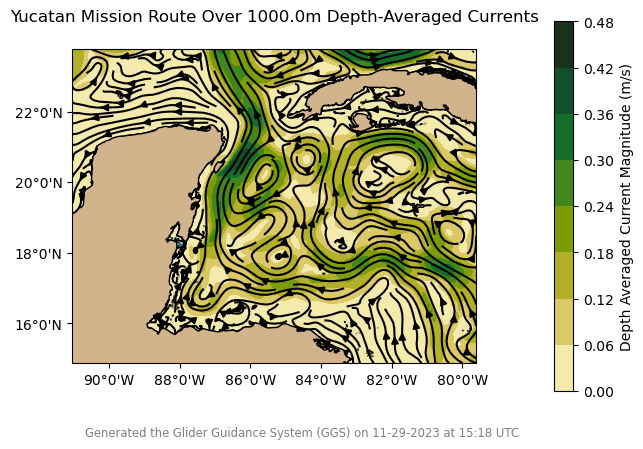

In [5]:
from SUP_plots import *

GGS_plot_currents(config, waypoints, directory, rtofs_data, u_avg, v_avg, magnitude, extent='data', map_lons=[-95, 0], map_lats=[0, 50], show_route=False)


In [6]:
### FUNCTION:
def calculate_nearpoint(dataset, target_lat, target_lon):
    
    '''
    Find the nearest point in the dataset to the input latitude and longitude.

    Args:
    - dataset (xarray.Dataset): The dataset to search in.
    - target_lat (float): The target latitude.
    - target_lon (float): The target longitude.

    Returns:
    - (y_index, x_index) (tuple): The indices of the nearest point in the dataset.
    - (lat_index, lon_index) (tuple): The coordinates of the nearest point in the dataset.
    '''

    lat_diff = dataset['lat'] - target_lat
    lon_diff = dataset['lon'] - target_lon
    distance_square = lat_diff**2 + lon_diff**2

    y_index, x_index = np.unravel_index(distance_square.argmin(), distance_square.shape)

    lat_index = dataset['lat'].isel(y=y_index, x=x_index).values
    lon_index = dataset['lon'].isel(y=y_index, x=x_index).values

    print(f"Input Coordinates: ({target_lat}, {target_lon})")
    print(f"Dataset Indices: ({y_index}, {x_index})")
    print(f"Dataset Coordinates: ({lat_index:.3f}, {lon_index:.3f})")

    return (y_index, x_index), (lat_index, lon_index)

# =========================
# X - MAIN
# =========================
target_lat = 20.5
target_lon = -86.0
dataset_indices, actual_coords = calculate_nearpoint(rtofs_data, target_lat, target_lon)


Input Coordinates: (20.5, -86.0)
Dataset Indices: (74, 63)
Dataset Coordinates: (20.508, -86.000)


Input Coordinates: (20.5, -86.0)
Dataset Indices: (74, 63)
Dataset Coordinates: (20.508, -86.000)
Input Coordinates: (20.5, -86.0)
Dataset Indices: (262, 175)
Dataset Coordinates: (20.508, -86.000)


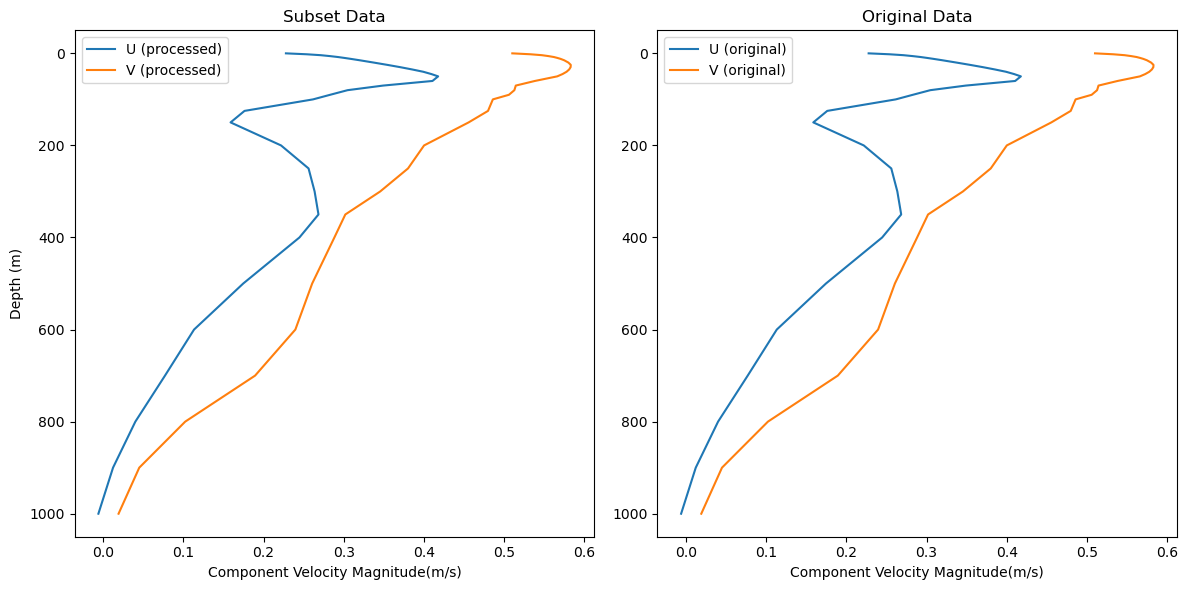

In [7]:
### FUNCTION:
def qc_currents_comparison(rtofs_data, rtofs_qc, latitude, longitude):
    
    '''
    Compare 'u' and 'v' profiles over depth from processed and original datasets.

    Args:
    - rtofs_data (xarray.Dataset): Processed dataset.
    - rtofs_qc (xarray.Dataset): Original dataset.
    - latitude (float): Latitude of the point of interest.
    - longitude (float): Longitude of the point of interest.

    Returns:
    - None
    '''

    (y_index, x_index), (lat_index, lon_index) = calculate_nearpoint(rtofs_data, latitude, longitude)
    (y_index_qc, x_index_qc), (lat_index_qc, lon_index_qc) = calculate_nearpoint(rtofs_qc, latitude, longitude)

    u_data = rtofs_data['u'][:, y_index, x_index]
    v_data = rtofs_data['v'][:, y_index, x_index]
    u_data_qc = rtofs_qc['u'][:, y_index_qc, x_index_qc]
    v_data_qc = rtofs_qc['v'][:, y_index_qc, x_index_qc]

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(u_data, rtofs_data['depth'], label='U (processed)')
    axes[0].plot(v_data, rtofs_data['depth'], label='V (processed)')
    axes[0].set_title('Subset Data')
    axes[0].set_xlabel('Component Velocity Magnitude(m/s)')
    axes[0].set_ylabel('Depth (m)')
    axes[0].invert_yaxis()
    axes[0].legend()

    axes[1].plot(u_data_qc, rtofs_qc['depth'], label='U (original)')
    axes[1].plot(v_data_qc, rtofs_qc['depth'], label='V (original)')
    axes[1].set_title('Original Data')
    axes[1].set_xlabel('Component Velocity Magnitude(m/s)')
    axes[1].invert_yaxis()
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# =========================
# X - MAIN
# =========================
latitude = 20.5
longitude = -86.0
qc_currents_comparison(rtofs_data, rtofs_qc, latitude, longitude)


Input Coordinates: (20.5, -86.0)
Dataset Indices: (74, 63)
Dataset Coordinates: (20.508, -86.000)


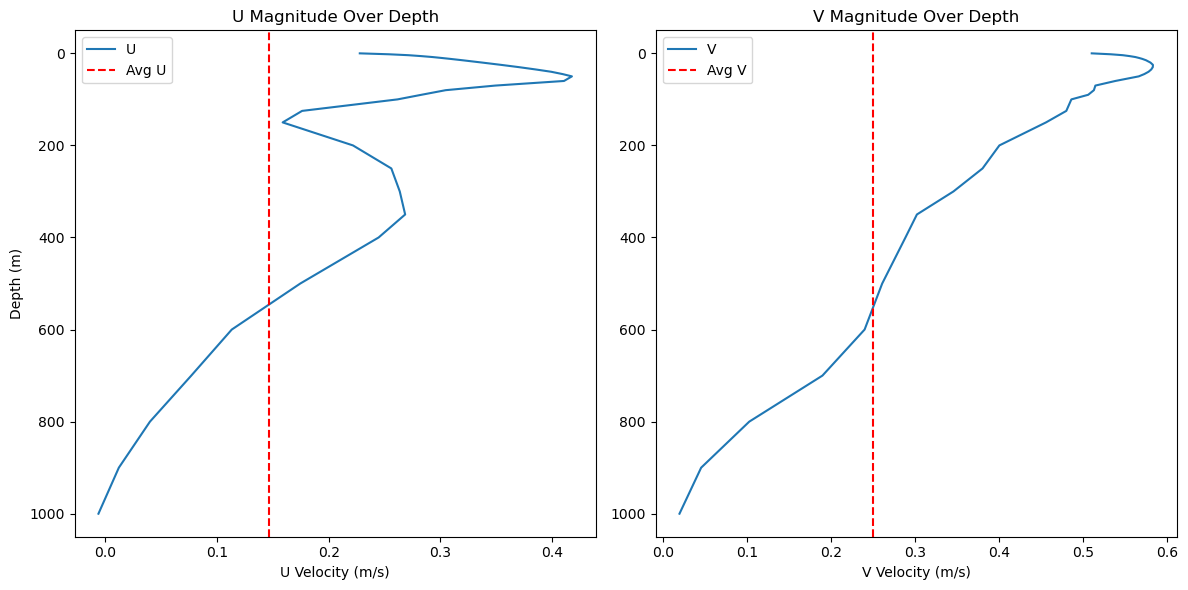

In [8]:
### FUNCTION:
def qc_currents_profile(rtofs_data, latitude, longitude):
    
    '''
    Plot 'u' and 'v' magnitudes over depth and thickness-weighted depth-averaged 'u' and 'v' as vertical lines.

    Args:
    - rtofs_data (xarray.Dataset): Dataset containing 'u' and 'v' data.
    - latitude (float): Latitude of the point of interest.
    - longitude (float): Longitude of the point of interest.

    Returns:
    - None
    '''

    (y_index, x_index), (lat_index, lon_index) = calculate_nearpoint(rtofs_data, latitude, longitude)

    u_data = rtofs_data['u'][:, y_index, x_index]
    v_data = rtofs_data['v'][:, y_index, x_index]

    u_avg, v_avg, magnitude, currents_data = compute_currents(rtofs_data)

    avg_u = u_avg.isel(y=y_index, x=x_index).values
    avg_v = v_avg.isel(y=y_index, x=x_index).values

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].plot(u_data, rtofs_data['depth'], label='U')
    axes[0].axvline(x=avg_u, color='r', linestyle='--', label='Avg U')
    axes[0].set_title('U Magnitude Over Depth')
    axes[0].set_xlabel('U Velocity (m/s)')
    axes[0].set_ylabel('Depth (m)')
    axes[0].invert_yaxis()
    axes[0].legend()

    axes[1].plot(v_data, rtofs_data['depth'], label='V')
    axes[1].axvline(x=avg_v, color='r', linestyle='--', label='Avg V')
    axes[1].set_title('V Magnitude Over Depth')
    axes[1].set_xlabel('V Velocity (m/s)')
    axes[1].invert_yaxis()
    axes[1].legend()

    plt.tight_layout()
    plt.show()

# =========================
# X - MAIN
# =========================
latitude = 20.5
longitude = -86.0
qc_currents_profile(rtofs_data, latitude, longitude)
